# Marmosets Download

In [12]:
# Download our training project:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

# Create the directory if it doesn't exist
os.makedirs('/content/train', exist_ok=True)
#os.makedirs('/content/test', exist_ok=True)

url_record = 'https://zenodo.org/api/records/5849371'
response = requests.get(url_record)

if response.status_code == 200:
    file = response.json()['files'][0]
    title = file['key']
    print(f"Downloading {title}...")
    with requests.get(file['links']['self'], stream=True) as r:
        with ZipFile(BytesIO(r.content)) as zf:
            zf.extractall(path='/content/train')
else:
    raise ValueError(f'The URL {url_record} could not be reached.')


#Set Up SAM-2 model

In [2]:
!pip install torch torchvision torchaudio
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

# Install OpenCV for image processing and matplotlib
!{sys.executable} -m pip install opencv-python matplotlib
# Install Segment Anything (SAM-2)
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

# Create checkpoints directory and download the pre-trained SAM-2 model checkpoint and save it in the checkpoints directory
!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.4.0+cu121
Torchvision version: 0.19.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-jsarg_qz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-jsarg_qz
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 7e1596c0b6462eb1d1ba7e1492430fed95023598
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-09-06 07:35:11--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]
S

In [6]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    # Enable TensorFloat-32 (TF32) on Ampere GPUs to improve performance without a significant loss in precision.
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [20]:
def show_mask(mask, cls, ax, borders = True):
    # Depending on the `cls` value, assign a different color to the mask
    if cls > 0.0:
        color = np.array([255/255, 255/255, 0/255, 0.3]) #R,G,B, transparency =yellow
    else:
        color = np.array([0/255, 255/255, 255/255, 0.3]) #R,G,B, transparency =cyan
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2  # Importing cv2 for drawing contours
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, cls, ax, marker_size=50):
    # Convert coords and labels to numpy arrays for proper indexing
    coords = np.array(coords)

    if cls < 1.0:
        color = 'orange'
    else:
        color = 'magenta'

    for pt in coords:
        x_coord = pt[0]
        y_coord = pt[1]
        if x_coord > 0 and y_coord > 0:
            ax.scatter(x_coord, y_coord, color=color, marker='o', s=marker_size, edgecolor='white', linewidth=1)
# Define a skeleton as a list of joint connections for drawing lines between keypoints
skeleton = [[0,1],[0,2],[0,3],[3,4],[4,5],[5,6],[4,7],[4,9],[7,8],[9,10],[6,11],[6,13],[11,12],[13,14]]

# Function to Draw Skeleton
def show_skeletons(keypoints, ax, cls, color='orange', width=2):
    for conn in skeleton: # For each connection
        start_idx, end_idx = conn
        x_start, y_start = keypoints[start_idx]  # Adjust index for 0-based
        x_end, y_end = keypoints[end_idx]  # Adjust index for 0-based
        if cls < 1.0:
            color = 'magenta'
        if x_start > 0 and y_start > 0 and x_end > 0 and y_end > 0:
            ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=width)

# Function to draw bounding boxes
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Main function to display masks, points, and bounding boxes on the image
def show_masks(image, masks, scores, cls, all_points, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.imshow(image)
        show_mask(mask, cls, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(all_points, cls, plt.gca())
            show_skeletons(all_points, plt.gca(), cls)
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

#SAM

In [9]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

# Build SAM2 model by loading configuration and checkpoint
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

# Initialize the image predictor using built SAM2 model
predictor = SAM2ImagePredictor(sam2_model)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


#Apply SAM

In [10]:
!pip install ultralytics
from ultralytics import YOLO

from google.colab import drive
drive.mount('/content/drive')

# Load YOLOv8 model
yolo_model = YOLO("/content/drive/My Drive/yolomodel.pt")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 21.7 MB/s eta 0:00:00
Mounted at /content/drive
WARNING ⚠️ /content/drive/My Drive/yolomodel.pt appears to require 'dill', which is not in Ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official Ultralytics model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.8s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect




0: 384x512 1 W, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 512)
Processing /content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01961.png


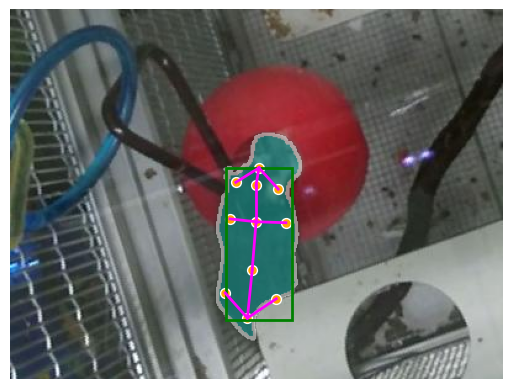


0: 512x512 1 B, 1 W, 33.2ms
Speed: 2.5ms preprocess, 33.2ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img03064.png


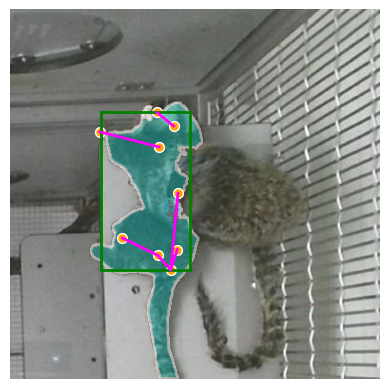

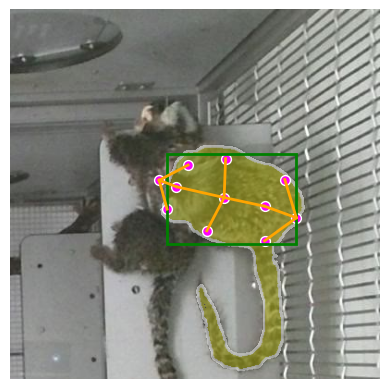


0: 512x512 1 W, 45.9ms
Speed: 4.6ms preprocess, 45.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01693.png


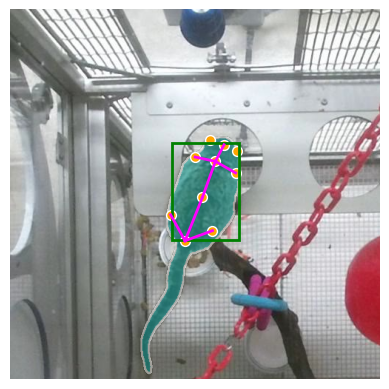


0: 512x512 1 B, 1 W, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img06627.png


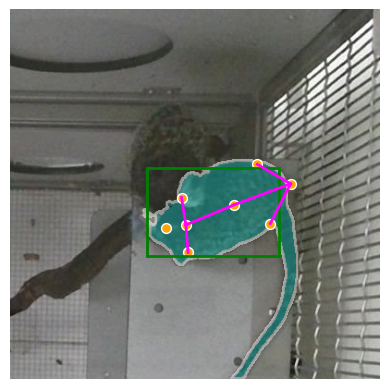

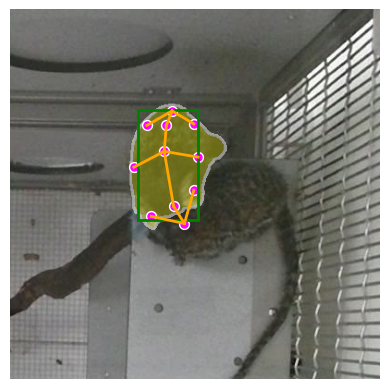


0: 512x512 1 B, 1 W, 34.9ms
Speed: 2.8ms preprocess, 34.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)
Processing /content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img02357.png


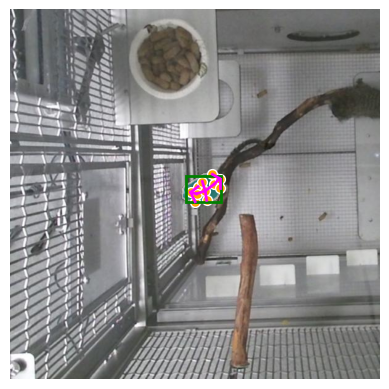

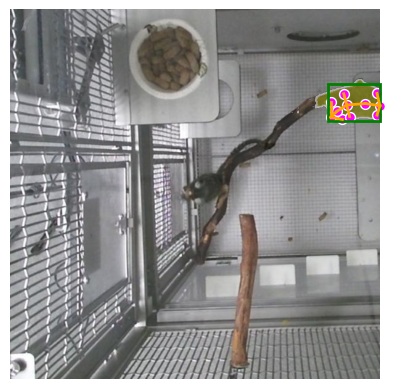

In [21]:
# Paths
# Get a list of image file paths
def get_image_list(image_dir):
    return [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

def segment_images(image_dir):
    # Get the list of images
    # next line for folder input
    # image_list = get_image_list(image_dir)
    image_list = image_dir

    # Process the results
    for image_path in image_list:
        # Run YOLO model on the image
        results = yolo_model([image_path])
        result = results[0]
        print(f"Processing {image_path}")

        # Check if keypoints are present in the results
        if result.keypoints is not None and len(result.keypoints) > 0:
            # Move tensor to CPU before converting to NumPy
            keypoints = result.keypoints.xy.cpu().numpy()
            boxes = result.boxes.xyxy.cpu().numpy()

            # Convert keypoints to the format expected by SAM-2
            idx=0
            for keypoint, box in zip(keypoints, boxes):
                points = []  # keypoints[0] to access first detection
                all_points = []

                # Collect points within the bounding box
                for kp in keypoint:
                    all_points.append([kp[0], kp[1]])
                    if kp[0] > 0.0 and kp[1] > 0.0:
                        if kp[0] < box[2] and kp[0] > box[0] and kp[1] > box[1] and kp[1] < box[3]:
                            points.append([kp[0], kp[1]])

                labels = [1] * len(points)  # All labels are 1

                # Open the image and set it in the predictor
                image = Image.open(image_path)
                predictor.set_image(image)

                #print the best mask
                masks, scores, logits = predictor.predict(
                    point_coords=points,
                    point_labels=labels,
                    multimask_output=True,
                )

                # Sort masks by scores in descending order
                sorted_ind = np.argsort(scores)[::-1]
                masks = masks[sorted_ind]
                scores = scores[sorted_ind]
                logits = logits[sorted_ind]
                # Use the mask highest score as input for next prediction
                mask_input = logits[np.argmax(scores), :, :]

                masks, scores, logits = predictor.predict(
                    point_coords=points,
                    point_labels=labels,
                    mask_input=mask_input[None, :, :],
                    multimask_output=False,
                )

                #SHOW MASK
                show_masks(image, masks, scores, idx, all_points, point_coords=points, input_labels=labels, box_coords=box)
                idx = idx + 1
        else:
            print(f"No keypoints found for {image_path}")

# Process images
images_dir = ['/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01961.png',
                  '/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img03064.png',
                  '/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img01693.png',
                  '/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img06627.png',
                  '/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1/img02357.png']
segment_images(images_dir)


#Gradio_ToBeContinue

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3e4fee55fb7ef641cb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# opening yolo here